In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from citipy import citipy
import warnings
warnings.filterwarnings('ignore')

In [8]:
#flight data to dataframe
flight_data_df = pd.read_csv("flights_sample_3m.csv")
flight_data_df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [9]:
#separate flight date, airline, flight number, origin city, dest city, cancelled
simplified_flight_df = flight_data_df[["FL_DATE","AIRLINE","ORIGIN_CITY","DEST_CITY","DEP_DELAY","CANCELLED"]]
simplified_flight_df

,FL_DATE,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED
0,2019-01-09,United Air Lines Inc.,"Fort Lauderdale, FL","Newark, NJ",-4.0,0.0
1,2022-11-19,Delta Air Lines Inc.,"Minneapolis, MN","Seattle, WA",-6.0,0.0
2,2022-07-22,United Air Lines Inc.,"Denver, CO","Minneapolis, MN",6.0,0.0
3,2023-03-06,Delta Air Lines Inc.,"Minneapolis, MN","San Francisco, CA",-1.0,0.0
4,2020-02-23,Spirit Air Lines,"Orlando, FL","Dallas/Fort Worth, TX",-2.0,0.0
...,...,...,...,...,...,...
2999995,2022-11-13,American Airlines Inc.,"Jacksonville, FL","Charlotte, NC",-2.0,0.0
2999996,2022-11-02,American Airlines Inc.,"Chicago, IL","Austin, TX",-6.0,0.0
2999997,2022-09-11,Delta Air Lines Inc.,"Huntsville, AL","Atlanta, GA",41.0,0.0
2999998,2019-11-13,Republic Airline,"Boston, MA","New York, NY",-5.0,0.0


In [10]:
simplified_flight_df["FL_DATE"] = pd.to_datetime(simplified_flight_df["FL_DATE"])

In [11]:
cancelled_flights_df = simplified_flight_df[simplified_flight_df["CANCELLED"] ==1]

#try:
    # Read the data from the CSV file
    #data = pd.read_csv(csv_file_path, usecols=['FL_DATE', 'CANCELLED'])

    # Convert the 'Flight Date' column to datetime format
cancelled_flights_df['FL_DATE'] = pd.to_datetime(cancelled_flights_df['FL_DATE'], errors='coerce', format='%Y-%m-%d')  
print("Datatype of 'FL_DATE' after conversion:", cancelled_flights_df['FL_DATE'].dtype)
    
     # Check for any rows where dates could not be converted
    #if data['FL_DATE'].isnull().any():
     #   print("Warning: Some dates could not be parsed.")

#except Exception as e:
  #  print(f"An error occurred: {e}")

Datatype of 'FL_DATE' after conversion: datetime64[ns]


In [12]:
    print("Datatype of 'FL_DATE' after conversion:", simplified_flight_df['FL_DATE'].dtype)


Datatype of 'FL_DATE' after conversion: datetime64[ns]


In [13]:
cancelled_flights_df

,FL_DATE,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED
14,2020-04-07,Southwest Airlines Co.,"San Jose, CA","Los Angeles, CA",NaN,1.0
45,2022-01-02,Republic Airline,"Chicago, IL","Washington, DC",NaN,1.0
80,2020-04-20,Southwest Airlines Co.,"Nashville, TN","Atlanta, GA",NaN,1.0
191,2021-12-31,Alaska Airlines Inc.,"Washington, DC","Los Angeles, CA",NaN,1.0
236,2020-04-14,Southwest Airlines Co.,"Las Vegas, NV","Houston, TX",NaN,1.0
...,...,...,...,...,...,...
2999779,2019-06-17,PSA Airlines Inc.,"Washington, DC","Akron, OH",NaN,1.0
2999865,2021-10-22,SkyWest Airlines Inc.,"Chicago, IL","Memphis, TN",NaN,1.0
2999910,2020-04-08,Allegiant Air,"Punta Gorda, FL","St. Cloud, MN",NaN,1.0
2999943,2020-03-30,American Airlines Inc.,"Fort Lauderdale, FL","Charlotte, NC",NaN,1.0


In [14]:
cancelled_flights_df.rename(columns={'FL_DATE': 'Flight Date'}, inplace=True)
cancelled_flights_df

,Flight Date,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED
14,2020-04-07,Southwest Airlines Co.,"San Jose, CA","Los Angeles, CA",NaN,1.0
45,2022-01-02,Republic Airline,"Chicago, IL","Washington, DC",NaN,1.0
80,2020-04-20,Southwest Airlines Co.,"Nashville, TN","Atlanta, GA",NaN,1.0
191,2021-12-31,Alaska Airlines Inc.,"Washington, DC","Los Angeles, CA",NaN,1.0
236,2020-04-14,Southwest Airlines Co.,"Las Vegas, NV","Houston, TX",NaN,1.0
...,...,...,...,...,...,...
2999779,2019-06-17,PSA Airlines Inc.,"Washington, DC","Akron, OH",NaN,1.0
2999865,2021-10-22,SkyWest Airlines Inc.,"Chicago, IL","Memphis, TN",NaN,1.0
2999910,2020-04-08,Allegiant Air,"Punta Gorda, FL","St. Cloud, MN",NaN,1.0
2999943,2020-03-30,American Airlines Inc.,"Fort Lauderdale, FL","Charlotte, NC",NaN,1.0


In [15]:

    if not cancelled_flights_df.empty:
         
     #Calculate cancellations by day
        daily_cancellations = cancelled_flights_df.groupby(cancelled_flights_df['Flight Date'].dt.date).size()
    
     #Calculate cancellations by month
        monthly_cancellations = cancelled_flights_df.groupby(cancelled_flights_df['Flight Date'].dt.to_period('M')).size()
    
     #Calculate cancellations by year
        yearly_cancellations = cancelled_flights_df.groupby(cancelled_flights_df['Flight Date'].dt.to_period('Y')).size()
    
    print("Daily Cancellations:\n", daily_cancellations)
    print("Monthly Cancellations:\n", monthly_cancellations)
    print("Yearly Cancellations:\n", yearly_cancellations)

Daily Cancellations:
 Flight Date
2019-01-01    10
2019-01-02    16
2019-01-03    15
2019-01-04     4
2019-01-05    12
              ..
2023-08-27    17
2023-08-28    11
2023-08-29    59
2023-08-30    88
2023-08-31    13
Length: 1679, dtype: int64
Monthly Cancellations:
 Flight Date
2019-01     1666
2019-02     1562
2019-03     1315
2019-04     1486
2019-05     1372
2019-06     1260
2019-07     1338
2019-08     1127
2019-09      956
2019-10      487
2019-11      461
2019-12      564
2020-01      752
2020-02      529
2020-03    11181
2020-04    13350
2020-05     1232
2020-06       73
2020-07      280
2020-08      392
2020-09      174
2020-10      187
2020-11      203
2020-12      404
2021-01      398
2021-02     1866
2021-03      546
2021-04      247
2021-05      226
2021-06      897
2021-07      942
2021-08     1829
2021-09      672
2021-10     1166
2021-11      375
2021-12     1368
2022-01     3437
2022-02     2249
2022-03      938
2022-04     1286
2022-05     1184
2022-06     1809
20

In [16]:
#Convert daily series to dataframe
daily_cancellations_df = daily_cancellations.reset_index(name='Cancellations')
daily_cancellations_df.rename(columns={'index': 'Flight Date'}, inplace=True)

#Change flight date index to datetime
daily_cancellations_df['Flight Date'] = pd.to_datetime(daily_cancellations_df['Flight Date'])
daily_cancellations_df

,Flight Date,Cancellations
0,2019-01-01,10
1,2019-01-02,16
2,2019-01-03,15
3,2019-01-04,4
4,2019-01-05,12
...,...,...
1674,2023-08-27,17
1675,2023-08-28,11
1676,2023-08-29,59
1677,2023-08-30,88


In [17]:
#Convert monthly series to dataframe
monthly_cancellations_df = monthly_cancellations.reset_index(name='Cancellations')
monthly_cancellations_df.rename(columns={'index': 'Flight Date'}, inplace=True)

#change index to flight date and cancellations
monthly_cancellations_df['Flight Date'] = monthly_cancellations_df['Flight Date'].dt.to_timestamp()
monthly_cancellations_df

#change flight date index to datetime
#monthly_cancellations_df['Flight Date'] = pd.to_datetime(monthly_cancellations_df['Flight Date'])

,Flight Date,Cancellations
0,2019-01-01,1666
1,2019-02-01,1562
2,2019-03-01,1315
3,2019-04-01,1486
4,2019-05-01,1372
5,2019-06-01,1260
6,2019-07-01,1338
7,2019-08-01,1127
8,2019-09-01,956
9,2019-10-01,487


In [18]:
#Convert monthly series to dataframe
yearly_cancellations_df = yearly_cancellations.reset_index(name='Cancellations')
yearly_cancellations_df.rename(columns={'index': 'Flight Date'}, inplace=True)

#change index to flight date and cancellations
yearly_cancellations_df['Flight Date'] = yearly_cancellations_df['Flight Date'].dt.to_timestamp()                                                    
yearly_cancellations_df

,Flight Date,Cancellations
0,2019-01-01,13594
1,2020-01-01,28757
2,2021-01-01,10532
3,2022-01-01,18448
4,2023-01-01,7809


In [19]:
#find average cancellation
daily_cancellations_avg = daily_cancellations_df.groupby('Flight Date')['Cancellations'].sum()
daily_cancellations_avg

#estimate days
start_date = '2019-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

daily_cancellations_complete = daily_cancellations_avg.reindex(date_range, fill_value=0)
# (replacing og DataFrame)
#data = {
  #  'Flight Date': pd.date_range(start='2019-01-01', periods=100, freq='D'),
   # 'Cancellations'
#}
#daily_cancellations_avg = pd.DataFrame(data)

# Step 1: Group by 'Flight Date' and sum up 'Cancellations'
#daily_cancellations_sum = daily_cancellations_avg.groupby('Flight Date')['Cancellations'].sum()

# Step 2: Reset the index if you need 'Flight Date' as a column
daily_cancellations_complete = daily_cancellations_complete.reset_index()

#filter the data to include only daily cancellations less than 300 and re plot it
#cancellation_series = daily_cancellations_complete[daily_cancellations_complete['Cancellations']<=300]

#exclude zero
cancellation_series = daily_cancellations_complete[(daily_cancellations_complete['Cancellations']<=60)&((daily_cancellations_complete['Cancellations']>=0))]

In [20]:
cancellation_series['Cancellations']

0       10
1       16
2       15
3        4
4       12
        ..
1448    19
1449    26
1450    56
1459    12
1460    18
Name: Cancellations, Length: 1215, dtype: int64

Median:13.0
Mean:17.640329218106995


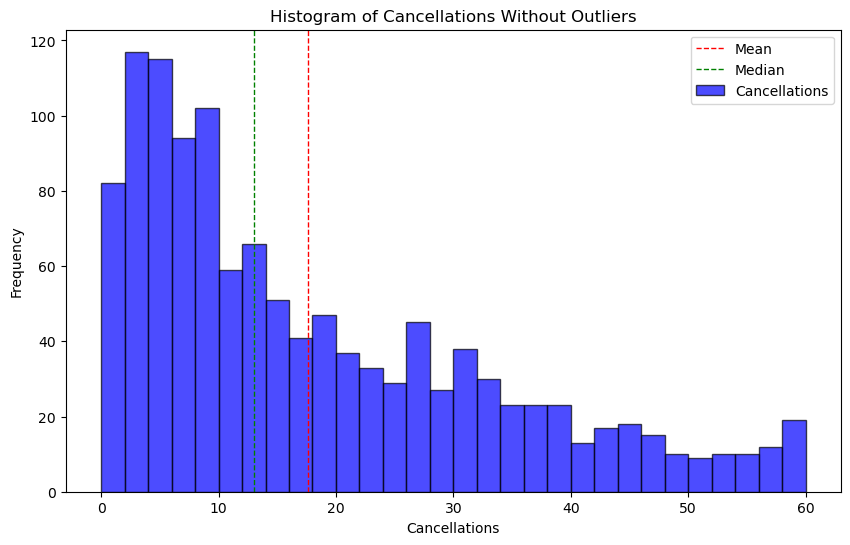

In [35]:
import matplotlib.pyplot as plt

# Creating the histogram
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as necessary
plt.hist(cancellation_series['Cancellations'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Calculate mean and median
mean_value = cancellation_series['Cancellations'].mean()
median_value = cancellation_series['Cancellations'].median()

print(f"Median:{median_value}")
print(f"Mean:{mean_value}")

# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1)

# Adding labels
plt.title('Histogram of Cancellations Without Outliers')
plt.xlabel('Cancellations')
plt.ylabel('Frequency')
plt.legend(['Mean', 'Median', 'Cancellations'])

# Show plot
plt.show()

Median:18.0
Mean:48.82340862422998


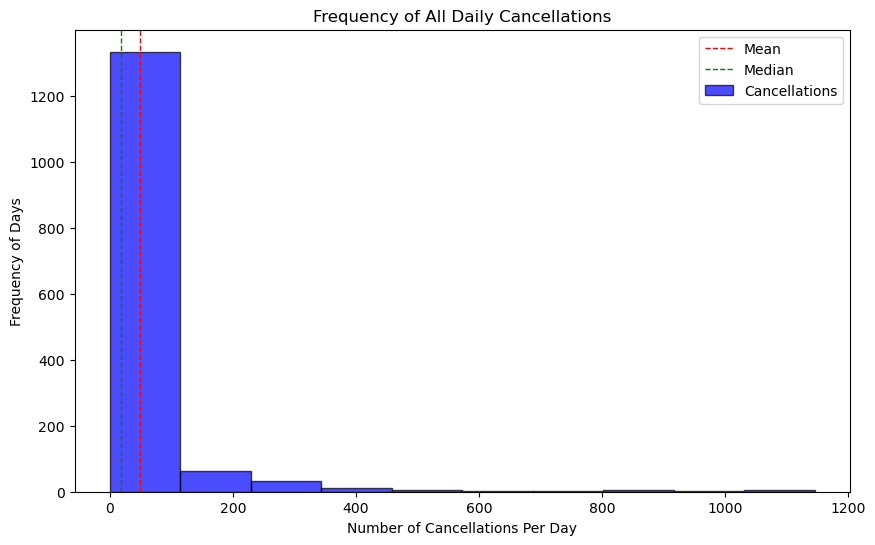

In [34]:
#data = {
   # 'Flight Date': ['2021-01-01', '2021-01-01', '2021-01-02', '2021-01-02', '2021-01-03', '2021-01-03', '2021-01-03'],
   # 'Cancelled': [1, 1, 0, 1, 1, 1, 0]  # Assuming '1' means cancelled
#}
#cancelled_flights_df = pd.DataFrame(data)

# Convert 'Flight Date' to datetime format 
#cancelled_flights_df['Flight Date'] = pd.to_datetime(cancelled_flights_df['Flight Date'])

# Group by 'Flight Date' and sum the 'Cancelled' column to get total cancellations per day
#daily_cancellations = cancelled_flights_df.groupby('Flight Date')['Cancelled'].sum()

plt.figure(figsize=(10, 6))
plt.hist(daily_cancellations_complete['Cancellations'], bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Frequency of All Daily Cancellations')
plt.xlabel('Number of Cancellations Per Day')
plt.ylabel('Frequency of Days')

# Calculate min and max for the data to set xticks appropriately
#data_min, data_max = min(daily_cancellations_complete), max(daily_cancellations_complete) #i need help with this

# Calculate mean and median
mean_value = daily_cancellations_complete['Cancellations'].mean()
median_value = daily_cancellations_complete['Cancellations'].median()

print(f"Median:{median_value}")
print(f"Mean:{mean_value}")

# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1)
plt.legend(['Mean', 'Median', 'Cancellations'])
plt.show()

In [28]:
print(f"Median:{median_value}")
print(f"Mean:{mean_value}")

Median:13.0
Mean:17.640329218106995


In [ ]:
# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1)

plt.show()
# Set x-ticks with smaller increments,
#plt.xticks(np.arange(start=np.floor(data_min), stop=np.ceil(data_max)+1, step=100))
#plt.yticks(np.arange(start=np.floor(data_min), stop=np.ceil(data_max)+1, step=100))
#plt.grid(True)
#plt.show()

In [23]:
#line graph for daily cancellations
#daily_cancellations_df, plt.plot(color="red", label="cancellations by day")

#Set y axis
#max_cancellations = daily_cancellations['Cancellations'].max()
#plt.yticks(np.arange(0, max_cancellations + 1, 10))  # Define ticks starting from 0 to max, with steps of 50

# Plotting the line graph
#plt.figure(figsize=(10, 5))  # Sets the figure size
#plt.plot(average_cancellations_per_day['Flight Date'], average_cancellations_per_day['Cancellations'], color='red', label='Cancellations by Day') 
#plt.title('Daily Flight Cancellations')  # Title of the graph
#plt.xlabel('Date')  # X-axis label
#plt.ylabel('Number of Cancellations')  # Y-axis label
#yticks = np.arange(0, max_cancellations + 1, 5000)
#plt.yticks(yticks, [f"{int(y)}" for y in yticks])  
#plt.legend()  # Show legend
#plt.grid(True)  # Show grid
#plt.xticks(rotation=45)  # Rotate date labels for better visibility
#plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
#plt.show()  # Display the plot

In [24]:
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt

# Generate the exact number of days from 2019 to 2022
#date_range = pd.date_range(start='2019-01-01', end='2022-12-31', freq='D')
# Ensure the number of random cancellations matches the number of days
#cancellations = np.random.randint(0, 2, size=len(date_range))

# Create the DataFrame
#quartiles_cancelled_flights_df = pd.DataFrame({
# 3'Flight Date': date_range,
  #  'Cancelled': cancellations
#})

# Convert 'Flight Date' to datetime format if not already (this step might actually be redundant)
#quartiles_cancelled_flights_df['Flight Date'] = pd.to_datetime(quartiles_cancelled_flights_df['Flight Date'])

# Group by year and sum the 'Cancelled' column to get total cancellations per year
#annual_cancellations = quartiles_cancelled_flights_df.groupby(quartiles_cancelled_flights_df['Flight Date'].dt.year)['Cancelled'].sum()

# Convert the groupby result to DataFrame for plotting
#annual_cancellations_df = annual_cancellations.reset_index()
#annual_cancellations_df.columns = ['Year', 'Total Cancellations']

# Create a box plot for the annual cancellations
#plt.figure(figsize=(8, 6))  # Sets the figure size
#plt.boxplot(annual_cancellations_df['Total Cancellations'], labels=annual_cancellations_df['Year'].astype(str))
#plt.title('Quartiles of Annual Cancellations (2019-2022)')  # Title of the plot
#plt.ylabel('Number of Cancellations')  # Y-axis label
#plt.grid(True)  # Adds gridlines for better readability
#plt.show()  # Displays the plot


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Cancellation numbers from yearly_cancellations_df
data = {
    'Year': [2019, 2020, 2021, 2022],
    'Total Cancellations': [13594, 28757, 10532, 18448]
}
annual_cancellations_df = pd.DataFrame(data)

# Ensure the data is in the correct form for plotting
# The data passed to boxplot should be a list of lists where each inner list contains data for one box
quartile_data_to_plot = [annual_cancellations_df[annual_cancellations_df['Year'] == year]['Total Cancellations'].tolist() for year in annual_cancellations_df['Year'].unique()]

plt.figure(figsize=(8, 6))  # Sets the figure size
plt.boxplot(data_to_plot, labels=annual_cancellations_df['Year'].astype(str))
plt.title('Quartiles of Annual Cancellations (2019-2022)')  # Title of the plot
plt.ylabel('Number of Cancellations')  # Y-axis label
plt.grid(True)  #Adds gridlines 
plt.show()  


cancellation_series = daily_cancellations_complete[daily_cancellations_complete['Cancellations']<=300]


NameError: name 'data_to_plot' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(daily_cancellations_complete['Cancellations'], bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Frequency of Daily Cancellations')
plt.xlabel('Number of Cancellations Per Day')
plt.ylabel('Frequency of Days')
# Calculate mean and median
mean_value = daily_cancellations_complete['Cancellations'].mean()
median_value = daily_cancellations_complete['Cancellations'].median()
# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1)
plt.show()